## Where to Open an Indian Restaurant at New York City</center>

### Import Packages

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
#!pip install geopy
from geopy.geocoders import Nominatim

import requests
#!pip install pandas.io
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import folium

### Declare credentials for Foursquare API

In [2]:
CLIENT_ID = 'APG5X2UNQQWYAP0K4TXBY45MRUCH1YVBCHZLVFJVU1YGWXVE'         #declare id here
CLIENT_SECRET = 'MVVBC01FOJ2G32MQHLKFZVXRI1AX0UOKW40DNLK1FHTROTMN'     #declare secret here
VERSION = '20180605'   # Version of API
radius = 500           # Radius to search places
LIMIT = 100            # Max no.of data points to be returned

In [4]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


### Read and declare the data 

In [5]:
with open('newyork_data.json') as json_data:      # Reading the json data saved locally
    ny_data = json.load(json_data)

ny_data = ny_data['features']                # The features key contains the data
ny_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

In [7]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
ny_geo_data = pd.DataFrame(columns=column_names)   

In [10]:
                # Create a dataframe to save the data into

for data in ny_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_geo_data = ny_geo_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [11]:
print(ny_geo_data.shape)
ny_geo_data.head(10)     # Display

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


### Count of NA's 

In [12]:
ny_geo_data.isna().sum()

Borough         0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64

### Count of Neighborhoods in each Borough

In [13]:
temp = ny_geo_data.groupby('Borough').count().reset_index().rename(columns={'Neighborhood':'Count'})[['Borough','Count']].sort_values('Count',ascending=False).reset_index(drop=True)#.plot(x='Borough',y='Count',kind='bar')
temp

,Borough,Count
0,Queens,81
1,Brooklyn,70
2,Staten Island,63
3,Bronx,52
4,Manhattan,40


### Function to the call the Foursquare API

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)   # The function returns a dataframe containing the nearby venues data obtained by calling the Foursquare API

### Queens

In [15]:
queens = ny_geo_data.loc[ny_geo_data['Borough']=='Queens'].reset_index(drop=True) # Filtering only Queens 
print(queens.shape)
queens.head()

(81, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [16]:
queens_venues = getNearbyVenues(names=queens['Neighborhood'],latitudes=queens['Latitude'],longitudes=queens['Longitude'])
print(queens_venues.shape)   # Data returned by the API
queens_venues.head(10)

(2117, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym
5,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant
6,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,40.768077,-73.911561,Middle Eastern Restaurant
7,Astoria,40.768509,-73.915654,Sitan Muay Thai,40.766108,-73.913224,Martial Arts School
8,Astoria,40.768509,-73.915654,Irish Rover,40.765835,-73.914647,Pub
9,Astoria,40.768509,-73.915654,The Gully,40.766719,-73.912410,Indian Restaurant


<b> Most common places in Queens</b>

In [17]:
q_temp = queens_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
q_temp.head()

,Venue Category,Count
0,Pizza Place,89
1,Deli / Bodega,77
2,Chinese Restaurant,72
3,Bakery,59
4,Donut Shop,55


### Brooklyn

In [18]:
brook = ny_geo_data.loc[ny_geo_data['Borough']=='Brooklyn'].reset_index(drop=True)  #Filtering only Brooklyn
print(brook.shape)
brook.head()

(70, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [19]:
brook_venues = getNearbyVenues(names=brook['Neighborhood'],latitudes=brook['Latitude'],longitudes=brook['Longitude'])
print(brook_venues.shape)
brook_venues.head(10)

(2758, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Georgian Dream Cafe and Bakery,40.625586,-74.030196,Caucasian Restaurant
4,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
5,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
6,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place
7,Bay Ridge,40.625801,-74.030621,Brooklyn Market,40.626939,-74.029948,Grocery Store
8,Bay Ridge,40.625801,-74.030621,Mimi Nails,40.622571,-74.031477,Spa
9,Bay Ridge,40.625801,-74.030621,Blue Door Souvlakia,40.624567,-74.030311,Greek Restaurant


<b> Most common places in Brooklyn </b>

In [20]:
bk_temp = brook_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
bk_temp.head()

,Venue Category,Count
0,Pizza Place,130
1,Coffee Shop,95
2,Bar,83
3,Deli / Bodega,73
4,Italian Restaurant,70


### Staten Island

In [21]:
stat_island = ny_geo_data.loc[ny_geo_data['Borough']=='Staten Island'].reset_index(drop=True)  #Filtering only Staten Island
print(stat_island.shape)
stat_island.head()

(63, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


In [24]:
si_venues = getNearbyVenues(names=stat_island['Neighborhood'],latitudes=stat_island['Latitude'],longitudes=stat_island['Longitude'])
print(si_venues.shape)
si_venues.head(10)

(828, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. George,40.644982,-74.079353,A&S Pizzeria,40.643940,-74.077626,Pizza Place
1,St. George,40.644982,-74.079353,Beso,40.643306,-74.076508,Tapas Restaurant
2,St. George,40.644982,-74.079353,Staten Island September 11 Memorial,40.646767,-74.076510,Monument / Landmark
3,St. George,40.644982,-74.079353,Richmond County Bank Ballpark,40.645056,-74.076864,Baseball Stadium
4,St. George,40.644982,-74.079353,Shake Shack,40.643660,-74.075891,Burger Joint
5,St. George,40.644982,-74.079353,Ruddy & Dean,40.644074,-74.076683,Bar
6,St. George,40.644982,-74.079353,Enoteca Maria,40.641941,-74.077320,Italian Restaurant
7,St. George,40.644982,-74.079353,St. George Theatre,40.642253,-74.077496,Theater
8,St. George,40.644982,-74.079353,Marie's 2,40.642176,-74.076669,Italian Restaurant
9,St. George,40.644982,-74.079353,The Gavel Grill,40.642157,-74.076674,American Restaurant


<b> Most common places in Staten Island </b>

In [25]:
si_temp = si_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
si_temp.head()

,Venue Category,Count
0,Pizza Place,53
1,Bus Stop,48
2,Italian Restaurant,40
3,Deli / Bodega,38
4,Bagel Shop,24


### Bronx

In [26]:
bronx = ny_geo_data.loc[ny_geo_data['Borough']=='Bronx'].reset_index(drop=True)  #Filtering only Bronx
print(bronx.shape)
bronx.head()

(52, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [27]:
bronx_venues = getNearbyVenues(names=bronx['Neighborhood'],latitudes=bronx['Latitude'],longitudes=bronx['Longitude'])
print(bronx_venues.shape)
bronx_venues.head(10)

(1221, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
5,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
6,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
7,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
8,Wakefield,40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,Laundromat
9,Co-op City,40.874294,-73.829939,Rite Aid,40.870345,-73.828302,Pharmacy


<b> Most common places in Bronx </b>

In [28]:
br_temp = bronx_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
br_temp.head()

,Venue Category,Count
0,Pizza Place,94
1,Deli / Bodega,58
2,Donut Shop,45
3,Pharmacy,43
4,Grocery Store,42


### Manhattan

In [29]:
manhattan = ny_geo_data.loc[ny_geo_data['Borough']=='Manhattan'].reset_index(drop=True)  #Filtering Manhattan
print(manhattan.shape)
manhattan.head()

(40, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [30]:
manhattan_venues = getNearbyVenues(names=manhattan['Neighborhood'],latitudes=manhattan['Latitude'],longitudes=manhattan['Longitude'])
print(manhattan_venues.shape)
manhattan_venues.head(10)

(3225, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
5,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym
6,Marble Hill,40.876551,-73.91066,Starbucks,40.873755,-73.908613,Coffee Shop
7,Marble Hill,40.876551,-73.91066,T.J. Maxx,40.877232,-73.905042,Department Store
8,Marble Hill,40.876551,-73.91066,TCR The Club of Riverdale,40.878628,-73.914568,Tennis Stadium
9,Marble Hill,40.876551,-73.91066,Rite Aid,40.875467,-73.908906,Pharmacy


<b> Most common places in Manhattan </b>

In [31]:
m_temp = manhattan_venues.groupby('Venue Category').count().sort_values('Neighborhood',ascending=False).reset_index().rename(columns={'Neighborhood':'Count'})[['Venue Category','Count']]
m_temp.head()

,Venue Category,Count
0,Coffee Shop,151
1,Italian Restaurant,128
2,Café,78
3,Pizza Place,77
4,Bakery,74


### Indian Restaurant's in various Boroughs

In [32]:
a = q_temp[q_temp['Venue Category']=='Indian Restaurant'].rename(columns={'Count':'Queens'}) # Getting the Number of Indian Restaurants in all the Boroughs
b = bk_temp[bk_temp['Venue Category']=='Indian Restaurant'].rename(columns={'Count':'Brooklyn'})
c = si_temp[si_temp['Venue Category']=='Indian Restaurant'].rename(columns={'Count':'Staten Island'})
d = br_temp[br_temp['Venue Category']=='Indian Restaurant'].rename(columns={'Count':'Bronx'})
e = m_temp[m_temp['Venue Category']=='Indian Restaurant'].rename(columns={'Count':'Manhattan'})

In [33]:
plt.rcParams['figure.figsize'] = 10,5

<b> Ranking the Borough's by number of Indian Restaurant's</b>

,Borough,Indian Restaurant
0,Manhattan,22
1,Queens,18
2,Brooklyn,16
3,Bronx,3
4,Staten Island,1


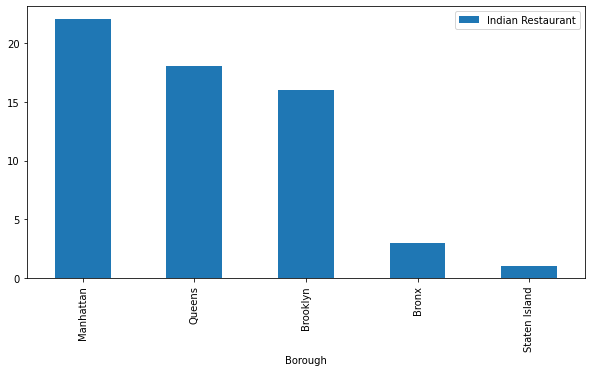

In [34]:
rest_count = pd.merge(a,b,on='Venue Category',how='inner').merge(c,on='Venue Category').merge(d,on='Venue Category').merge(e,on='Venue Category')
rest_count = rest_count.transpose().reset_index() # Merging all the Boroughs and transpose
rest_count.columns=['Borough','Indian Restaurant']
rest_count.drop([0],inplace=True)
rest_count = rest_count.sort_values('Indian Restaurant',ascending=False).reset_index(drop=True) # Sorting
rest_count.plot(x='Borough',kind='bar')
rest_count

<b> Manhattan has the highest number of restaurants (22) and Queens is 2<sup>nd</sup> highest with 18 Places.<br>Before we analyze a Borough we must look into the Indian Demographic of each of them.</b>

### Getting Indians living in NYC
<b>Based on a 2014 American Community Survey. (ACS) </b>

In [35]:
ny_india = pd.read_html('https://en.wikipedia.org/wiki/Indians_in_the_New_York_City_metropolitan_region') # Scraping Demographics Data
ny_india = ny_india[1]
ny_india.head()

,Rank,Borough,City,Indian Americans,Density of Indian Americans per square mile,Percentage of Indian Americans in municipality's population
0,1.0,Queens (2014)[32],New York City,144896,1326.5,6.2
1,2.0,Brooklyn (2012),New York City,25270,357.9,1.0
2,3.0,Manhattan (2012),New York City,24359,1060.9,1.5
3,4.0,The Bronx (2012),New York City,16748,398.6,1.2
4,5.0,Staten Island (2012),New York City,6646,113.6,1.4


### Cleaning the Demographics Data

In [36]:
ny_india.drop(columns=['Rank','City'],axis=1,inplace=True)      # Drop the rank and City and the Total Row
ny_india.drop([5],axis=0,inplace=True)

,Borough,Indian Americans,Density of Indian Americans per square mile,% Population
0,Queens,144896,1326.5,6.2
1,Brooklyn,25270,357.9,1.0
2,Staten Island,24359,1060.9,1.5
3,Bronx,16748,398.6,1.2
4,Manhattan,6646,113.6,1.4


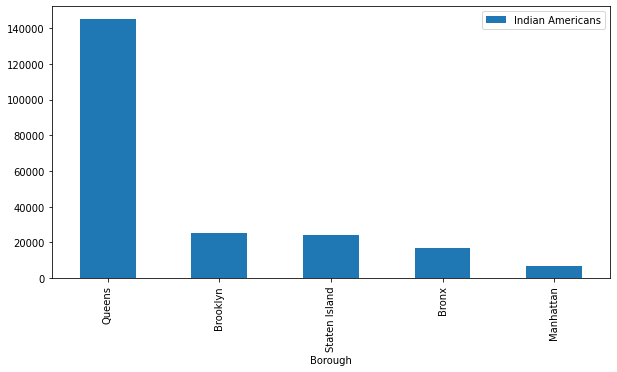

In [37]:
ny_india['Borough'] = temp['Borough']        # Making the data more presentable
ny_india.rename(columns={'''Percentage of Indian Americans in municipality's population''':'% Population'},inplace=True)
ny_india.plot(x='Borough',y='Indian Americans',kind='bar')
ny_india

### Merging the Count of Restaurants and the Indian Demographic

In [38]:
pd.merge(rest_count,ny_india,on='Borough',how='inner').sort_values(by=['Indian Americans','Indian Restaurant'],ascending=False).reset_index(drop=True)

,Borough,Indian Restaurant,Indian Americans,Density of Indian Americans per square mile,% Population
0,Queens,18,144896,1326.5,6.2
1,Brooklyn,16,25270,357.9,1.0
2,Staten Island,1,24359,1060.9,1.5
3,Bronx,3,16748,398.6,1.2
4,Manhattan,22,6646,113.6,1.4


### Initial Analysis:

<b><p> Although Queens has the highest population of Indian Americans and the highest % population, we don't consider it as there are already numerous pre-existing restaurants.</p> <br> 
<p> Manhattan has very few Indian Americans with a low % and also has the most no. of Indian Restaurants, so we eliminate it. </p> <br> 
<p> Staten Island seems like a good first choice to begin our analysis as it it does not have too may restaurants with a decent Indian Population. <br> 

## Case: Opeing Restaurant at Staten Island

### Visualizaing a map of Staten Island

In [39]:
def location(place): # Function uses Geoencoder to get the coordinates of a location 
    l=[]
    address = place
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    l.append(latitude)
    l.append(longitude)
    print('The geograpical coordinate of {} are {}, {}.'.format(place.split(',')[0],latitude, longitude))
    return l   

In [40]:
loc = location('Staten Island, NY')

The geograpical coordinate of Staten Island are 40.5834557, -74.1496048.


In [41]:
def plot_map(df,loc,zoom):  # Function to plot a map, it takes a dataframe,list location and zoom value as parameters 
    #create a map with the location values
    map_df = folium.Map(location=loc, zoom_start=zoom)
    # add markers to map
    for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='purple',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_df)  
    #return the map object
    return map_df

In [43]:
plot_map(stat_island,loc,zoom=11)

### Filtering

In [44]:
si_indian = si_venues[si_venues['Venue Category']=='Indian Restaurant'].reset_index(drop=True)
si_indian.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New Dorp,40.572572,-74.116479,Taste Of India II,40.572127,-74.112674,Indian Restaurant


### OneHot Encoding the Cateogories

In [46]:
ny_onehot = pd.get_dummies(si_venues[['Venue Category']], prefix="", prefix_sep="")   # Using dummies to Encode
ny_onehot['Neighborhood'] = si_venues['Neighborhood']

fixed_columns = [ny_onehot.columns[102]] + list(ny_onehot.columns[:102]) + list(ny_onehot.columns[103:])  # Getting the Neighborhoods column to the first
ny_onehot = ny_onehot[fixed_columns]

print(ny_onehot.shape)
ny_onehot.head()

(828, 182)


,Mexican Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Big Box Store,Board Shop,Boat or Ferry,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Clothing Store,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Event Service,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Truck,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Lawyer,Liquor Store,Locksmith,Market,Martial Arts School,Mattress Store,Mediterranean Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Nightlife Spot,Optical Shop,Outdoors & Recreation,Outlet Mall,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Professional & Other Places,Pub,Racetrack,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoothie Shop,Snack Place,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toll Plaza,Tourist Information Center,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. George
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. George
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. George
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Grouping the Categories

In [47]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()  # Grouping and taking the mean
print(ny_grouped.shape)
ny_grouped.head()

(61, 182)


,Neighborhood,Mexican Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Big Box Store,Board Shop,Boat or Ferry,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Clothing Store,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Event Service,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flower Shop,Food,Food & Drink Shop,Food Truck,French Restaurant,Furniture / Home Store,Gas Station,Gastropub,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Lawyer,Liquor Store,Locksmith,Market,Martial Arts School,Mattress Store,Mediterranean Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Nightlife Spot,Optical Shop,Outdoors & Recreation,Outlet Mall,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Professional & Other Places,Pub,Racetrack,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoothie Shop,Snack Place,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toll Plaza,Tourist Information Center,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.111111,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.000,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
1,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.0,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [49]:
grouped_indian = ny_grouped[['Neighborhood','Indian Restaurant']]  # Only Indian Restaurant needs to be considered
grouped_indian.head(20)

,Neighborhood,Indian Restaurant
0,Annadale,0.0
1,Arden Heights,0.0
2,Arlington,0.0
3,Arrochar,0.0
4,Bay Terrace,0.0
5,Bloomfield,0.0
6,Bulls Head,0.0
7,Butler Manor,0.0
8,Castleton Corners,0.0
9,Charleston,0.0


### Clustering

<b> Elbow Method is used to determine the k-value</b>

In [50]:
cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) # Range of k-values
    KM.fit(grouped_indian.drop(columns=['Neighborhood'])) 
    cost.append(KM.inertia_)     # Getting the cost

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ConvergenceWarni

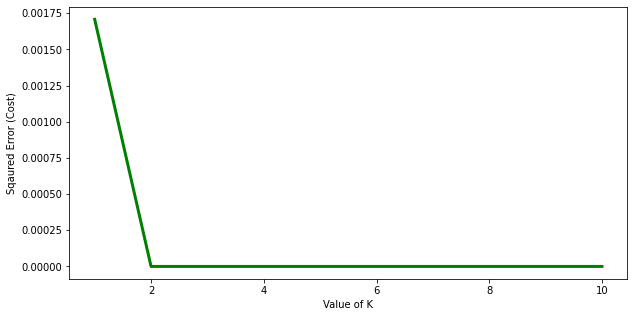

In [51]:
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

In [52]:
kclusters = 3     # No.of Clusters
ny_grouped_clustering = grouped_indian.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [53]:
grouped = grouped_indian.copy(deep=True)
grouped['Cluster Labels'] = kmeans.labels_    # Adding the labels to the data
grouped['Cluster Labels'] = grouped['Cluster Labels'].astype(int)  # Float is sometimes returned
print(grouped.shape)
grouped.head(10)

(61, 3)


,Neighborhood,Indian Restaurant,Cluster Labels
0,Annadale,0.0,2
1,Arden Heights,0.0,2
2,Arlington,0.0,2
3,Arrochar,0.0,2
4,Bay Terrace,0.0,2
5,Bloomfield,0.0,2
6,Bulls Head,0.0,2
7,Butler Manor,0.0,2
8,Castleton Corners,0.0,2
9,Charleston,0.0,2


In [54]:
to_merged = grouped.join(si_venues.set_index("Neighborhood"), on="Neighborhood") # Merge with the original data
print(to_merged.shape)
to_merged.head()

(828, 9)


,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annadale,0.0,2,40.538114,-74.178549,Annadale Diner,40.542079,-74.177325,Diner
0,Annadale,0.0,2,40.538114,-74.178549,Il Sogno,40.541286,-74.178489,Restaurant
0,Annadale,0.0,2,40.538114,-74.178549,MTA SIR - Annadale,40.540482,-74.178185,Train Station
0,Annadale,0.0,2,40.538114,-74.178549,Crown Palace,40.540334,-74.176147,Food
0,Annadale,0.0,2,40.538114,-74.178549,Creative Nails,40.540956,-74.177150,Cosmetics Shop


### Visualizaing the Clusters

In [57]:
loc = location('Staten Island, NY')

The geograpical coordinate of Staten Island are 40.5834557, -74.1496048.


In [58]:
map_clusters = folium.Map(location=loc, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [59]:
to_merged[to_merged['Cluster Labels']==0]  # Cluster 0

,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category


In [60]:
to_merged[to_merged['Cluster Labels']==1]  # Cluster 1

,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
32,New Dorp,0.041667,1,40.572572,-74.116479,La Strada,40.573743,-74.115627,Italian Restaurant
32,New Dorp,0.041667,1,40.572572,-74.116479,Pizzeria Giove,40.572256,-74.113123,Pizza Place
32,New Dorp,0.041667,1,40.572572,-74.116479,Piece A Cake,40.573309,-74.115063,Bakery
32,New Dorp,0.041667,1,40.572572,-74.116479,Plaza Bagels & Deli,40.573387,-74.117688,Bagel Shop
32,New Dorp,0.041667,1,40.572572,-74.116479,Brioso,40.573052,-74.114789,Italian Restaurant
32,New Dorp,0.041667,1,40.572572,-74.116479,Nori,40.573737,-74.117523,Sushi Restaurant
32,New Dorp,0.041667,1,40.572572,-74.116479,Taste Of India II,40.572127,-74.112674,Indian Restaurant
32,New Dorp,0.041667,1,40.572572,-74.116479,Cantina Mexicana,40.573802,-74.116061,Mexican Restaurant
32,New Dorp,0.041667,1,40.572572,-74.116479,Something Sweet,40.571643,-74.112107,Dessert Shop
32,New Dorp,0.041667,1,40.572572,-74.116479,A.F Bennett Salon & Wellness Spa,40.571100,-74.111029,Salon / Barbershop


In [61]:
to_merged[to_merged['Cluster Labels']==2]  # Cluster 2

,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annadale,0.0,2,40.538114,-74.178549,Annadale Diner,40.542079,-74.177325,Diner
0,Annadale,0.0,2,40.538114,-74.178549,Il Sogno,40.541286,-74.178489,Restaurant
0,Annadale,0.0,2,40.538114,-74.178549,MTA SIR - Annadale,40.540482,-74.178185,Train Station
0,Annadale,0.0,2,40.538114,-74.178549,Crown Palace,40.540334,-74.176147,Food
0,Annadale,0.0,2,40.538114,-74.178549,Creative Nails,40.540956,-74.177150,Cosmetics Shop
0,Annadale,0.0,2,40.538114,-74.178549,Major League Liquors,40.541203,-74.177107,Liquor Store
0,Annadale,0.0,2,40.538114,-74.178549,Trio pizzeria,40.541478,-74.178428,Pizza Place
0,Annadale,0.0,2,40.538114,-74.178549,Square Pizza,40.541462,-74.177444,Pizza Place
0,Annadale,0.0,2,40.538114,-74.178549,The Curly Wolf Saloon,40.541741,-74.177299,Pub
1,Arden Heights,0.0,2,40.549286,-74.185887,Villa Monte Pizzeria & Restaurant,40.552555,-74.186212,Pizza Place


In [62]:
t = to_merged[to_merged['Cluster Labels']==0]
print('Number of Indian Restaurants in Cluster 0: {}'.format(t[t['Venue Category']=='Indian Restaurant'].count()[0]))
t = to_merged[to_merged['Cluster Labels']==1]
print('Number of Indian Restaurants in Cluster 1: {}'.format(t[t['Venue Category']=='Indian Restaurant'].count()[0]))
t = to_merged[to_merged['Cluster Labels']==2]
print('Number of Indian Restaurants in Cluster 2: {}'.format(t[t['Venue Category']=='Indian Restaurant'].count()[0]))

Number of Indian Restaurants in Cluster 0: 0
Number of Indian Restaurants in Cluster 1: 1
Number of Indian Restaurants in Cluster 2: 0


### New Analysis :

<ul>
<b> <li> <p> Cluster 1 has the one Indian Restaurants and is therefore not considered.</p> <br> </li>
        <li> <p> <u> Cluster 0 and 2 </u> is ideal as no restaurants are present. Therefore we can look into the places in these Clusters.</p> <br> </li> </b> 
</ul>

### Analyzing Cluster 2

<b> Most common Type of Restaurant(s) in each Neighborhood. </b>

In [66]:
temp = to_merged[to_merged['Cluster Labels']==2]
x = temp[temp['Venue Category'].str.contains('Restaurant')].groupby(['Neighborhood','Venue Category']).count()
y = x.reset_index().rename(columns={'Venue':'Count'})[['Neighborhood','Venue Category','Count']].sort_values(by='Count',ascending=False).reset_index(drop=True).head(6)
y

,Neighborhood,Venue Category,Count
0,Old Town,Italian Restaurant,4
1,Eltingville,Sushi Restaurant,4
2,Shore Acres,Italian Restaurant,3
3,Bulls Head,Chinese Restaurant,3
4,Grant City,Asian Restaurant,2
5,Dongan Hills,Italian Restaurant,2


<b> Most common Places in the Cluster. </b>

In [67]:
temp.groupby('Venue Category').count().reset_index().rename(columns={'Indian Restaurant':'Count'})[['Venue Category','Count']].sort_values('Count',ascending=False).reset_index(drop=True).head(10)

,Venue Category,Count
0,Pizza Place,51
1,Bus Stop,48
2,Italian Restaurant,37
3,Deli / Bodega,36
4,Bagel Shop,23
5,Grocery Store,21
6,Sandwich Place,20
7,Pharmacy,19
8,Bar,18
9,Chinese Restaurant,17


<p style="font-size:18px" "font-family:helvetica"> From the table above we can see that the most common places in this Cluster are Pizza Places, Italian restaurants, bagel shops etc. The 2 most common type of restaurants are <u> Italian </u> and <u> Chinese </u>.</p>

<b> Most Common Neighborhoods in the Cluster </b>

In [68]:
clus_2  = to_merged[to_merged['Cluster Labels']==2].groupby('Neighborhood').count().reset_index().rename(columns={'Indian Restaurant':'Count'})[['Neighborhood','Count']].sort_values('Count',ascending=False).reset_index(drop=True)
print('Number of Neighborhoods: {}'.format(len(clus_2)))
clus_2.head()

Number of Neighborhoods: 60


,Neighborhood,Count
0,Bulls Head,44
1,West Brighton,38
2,Eltingville,37
3,Stapleton,37
4,St. George,35


### Final Analysis : 

<p style="font-size:18px" "font-family:helvetica"> Looking at nearby venues, it seems Cluster 2 might be a good location as there are not Indian restaurants in these areas. There are 60 odd neighborhoods present in the Cluster and the most common ones being <b> Bulls Head, West Brighton, Eltingville, Stapleton and St. George </b> in <b> Staten Island. </b></p>

<p style="font-size:18px" "font-family:helvetica"> Therefore our Indian Restaurant can be opened in any of these neighborhoods  with little competition to other chinese or Italian restaurants and no competition with Indian restaurants at all. <br> 
Nonetheless, if the food is affordable, authentic and has good taste, I am confident that it will have great following everywhere. </p>